In [1]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
print(tf.__version__)
AUTOTUNE = tf.data.experimental.AUTOTUNE

import deepcell
# Changed from before due to new placement of Track, concat_tracks
from deepcell_tracking.utils import load_trks
from deepcell.data.tracking import Track, concat_tracks
##############
from sklearn.model_selection import train_test_split
from deepcell.utils.data_utils import reshape_movie
from deepcell.utils.transform_utils import erode_edges
from deepcell.data import split_dataset
from deepcell_toolbox.processing import normalize, histogram_normalization

import spektral

2.8.0


# Load images from TF Records

In [2]:
def parse_tfr_element(element):
    #use the same structure as above; it's kinda an outline of the structure we now want to create
    data = {
        'height': tf.io.FixedLenFeature([], tf.int64),
        'width':tf.io.FixedLenFeature([], tf.int64),
        'depth':tf.io.FixedLenFeature([], tf.int64),
        'raw_image' : tf.io.FixedLenFeature([], tf.string)
    }


    content = tf.io.parse_single_example(element, data)

    height = content['height']
    width = content['width']
    depth = content['depth']
    raw_image = content['raw_image']
    

    #get our 'feature'-- our image -- and reshape it appropriately
    feature = tf.io.parse_tensor(raw_image, out_type=tf.float32)
    feature = tf.reshape(feature, shape=[height,width,depth])
    return (feature, feature)

In [3]:
def get_dataset(filename, batch_size=1, buffer_size=256,
                    seed=None):
    #create the dataset
    dataset = tf.data.TFRecordDataset(filename)

    #pass every single feature through our mapping function
    dataset = dataset.map(
      parse_tfr_element
    )
    
    dataset = dataset.shuffle(buffer_size, seed=seed)

    dataset = dataset.repeat().batch(batch_size)
    
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [4]:
val_dataset = get_dataset("/data/tf_records/val_big_full.tfrecords", batch_size=100)
train_dataset = get_dataset("/data/tf_records/train_big_full.tfrecords", batch_size=100)

2022-08-26 05:40:57.272323: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-26 05:40:58.000153: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14128 MB memory:  -> device: 0, name: Tesla V100-DGXS-16GB, pci bus id: 0000:0f:00.0, compute capability: 7.0


In [5]:
for sample in val_dataset.take(5310):
    if np.any((sample[0] < 0)|(sample[0] > 1 )):
        print('Not normalized')

for sample in train_dataset.take(26167):
    if np.any((sample[0] < 0)|(sample[0] > 1 )):
        print('Not normalized')

In [6]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

In [7]:
class VAE:
    
    def __init__(self, dim_z, kl_weight, learning_rate, n_filters, n_layers, side):
        # change dim from (28, 28, 1)
        self.dim_x = (side, side, 1)
        self.dim_z = dim_z
        self.kl_weight = kl_weight
        self.learning_rate = learning_rate
        self.n_filters = n_filters
        self.n_layers = n_layers
        self.side = side

    # Sequential API encoder
    def encoder_z(self):
        # define prior distribution for the code, which is an isotropic Gaussian
        prior = tfd.Independent(tfd.Normal(loc=tf.zeros(self.dim_z), scale=1.), 
                                reinterpreted_batch_ndims=1)
        # build layers argument for tfk.Sequential()
        input_shape = self.dim_x
        layers = [tfkl.InputLayer(input_shape=input_shape)]
        for i in range(self.n_layers):
            layers.append(tfkl.Conv2D(filters=self.n_filters, kernel_size=3, strides=(2,2), 
                                  padding='valid', activation='relu'))
        layers.append(tfkl.Flatten())
        # the following two lines set the output to be a probabilistic distribution
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_z), 
                                 activation=None, name='z_params'))
        layers.append(tfpl.IndependentNormal(self.dim_z, 
            convert_to_tensor_fn=tfd.Distribution.sample, 
            activity_regularizer=tfpl.KLDivergenceRegularizer(prior, weight=self.kl_weight), 
            name='z_layer'))
        return tfk.Sequential(layers, name='encoder')
    
    # Sequential API decoder
    def decoder_x(self):
        layers = [tfkl.InputLayer(input_shape=self.dim_z)]
        # probably 7 before since 28/2/2 = 7, so changing to 32/2/2 = 8
        frac = 2**self.n_layers
        layers.append(tfkl.Dense(int((self.side/frac)**2*32), activation=None))
        layers.append(tfkl.Reshape((int(self.side/frac),int(self.side/frac),32)))
        for i in range(self.n_layers):
            layers.append(tfkl.Conv2DTranspose(filters=self.n_filters, kernel_size=3, strides=2, 
                                           padding='same', activation='relu'))
        layers.append(tfkl.Conv2DTranspose(filters=1, kernel_size=3, strides=1, 
                                           padding='same'))
        layers.append(tfkl.Flatten())
        # note that here we don't need 
        # `tfkl.Dense(tfpl.IndependentBernoulli.params_size(self.dim_x))` because 
        # we've restored the desired input shape with the last Conv2DTranspose layer
        layers.append(tfkl.Dense(tfpl.IndependentNormal.params_size(self.dim_x), 
                                 activation=None, name='x_params'))
        layers.append(tfpl.IndependentNormal(self.dim_x,
            name='x_layer'))
        return tfk.Sequential(layers, name='decoder')
    
    def build_vae_keras_model(self):
        x_input = tfk.Input(shape=self.dim_x)
        encoder = self.encoder_z()
        decoder = self.decoder_x()
        z = encoder(x_input)

        # compile VAE model
        model = tfk.Model(inputs=x_input, outputs=decoder(z))
        model.compile(loss=negative_log_likelihood, 
                      optimizer=tfk.optimizers.Adam(self.learning_rate))
        return model

# the negative of log-likelihood for probabilistic output
negative_log_likelihood = lambda x, rv_x: -rv_x.log_prob(x)

In [10]:
# VAE with 4 encoding and decoding layers, 64 filters per convolution, KL-divergence weight 1
vae = VAE(16, 1, 1e-3, 64, 4, 64)
AE = vae.build_vae_keras_model()

In [11]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 26167
validation_steps = 5310
n_epochs = 8
model_path = '/data/models/big_img_4_layers_full_dataset'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=True)
]

loss_history = AE.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

Epoch 1/8
26166/26167 [============================>.] - ETA: 0s - loss: -7939.8706
Epoch 1: val_loss improved from inf to 24875.70898, saving model to /data/models/big_img_4_layers_full_dataset
26167/26167 [==============================] - 627s 24ms/step - loss: -7939.9341 - val_loss: 24875.7090 - lr: 0.0010
Epoch 2/8
26167/26167 [==============================] - ETA: 0s - loss: -9257.0479
Epoch 2: val_loss improved from 24875.70898 to 1808.11523, saving model to /data/models/big_img_4_layers_full_dataset
26167/26167 [==============================] - 607s 23ms/step - loss: -9257.0479 - val_loss: 1808.1152 - lr: 0.0010
Epoch 3/8
26167/26167 [==============================] - ETA: 0s - loss: -9738.2266
Epoch 3: val_loss did not improve from 1808.11523
26167/26167 [==============================] - 610s 23ms/step - loss: -9738.2266 - val_loss: 234794.4219 - lr: 0.0010
Epoch 4/8
26167/26167 [==============================] - ETA: 0s - loss: -8696.3311
Epoch 4: val_loss did not improve 

In [13]:
val_trks = load_trks(os.path.join('/data/tracking-nuclear', 'val.trks'))
with tf.device('/cpu:0'):
    val_tracks = Track(tracked_data=val_trks,
                   appearance_dim=64,
                   distance_threshold=64,
                   crop_mode='fixed')

    print('Done creating Track objects.')

#     write_tracking_dataset_to_tfr(val_tracks, filename='val_big', good_imgs=val_good_imgs)

100%|███████████████████████████████████████████| 27/27 [02:39<00:00,  5.90s/it]


Done creating Track objects.


In [12]:
import matplotlib.pyplot as plt

x = np.array([train_tracks.appearances[0][2][16]])
xhat = AE(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

NameError: name 'train_tracks' is not defined

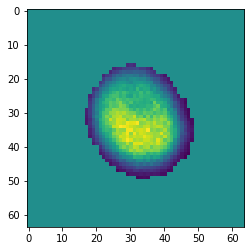

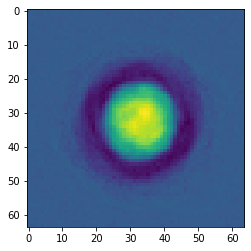

In [16]:
x = np.array([train_tracks.appearances[0][2][11]])
xhat = AE(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

In [28]:
type(xhat)

tensorflow.python.framework.ops.EagerTensor

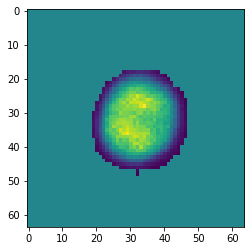

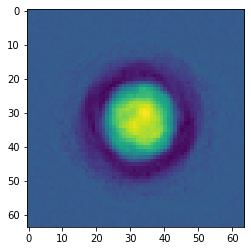

In [17]:
x = np.array([train_tracks.appearances[0][12][8]])
xhat = AE(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

In [12]:
# Compressing embedding space to 16 dimensions
vae_comp = VAE(16, 1, 1e-3, 64, 4, 64)
AE_comp = vae_comp.build_vae_keras_model()

2022-08-23 22:54:31.704047: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/optimizers/rectified_adam.py:120: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [13]:
from tensorflow_addons.optimizers import RectifiedAdam as RAdam
from deepcell import train_utils

steps_per_epoch = 3838
validation_steps = 895
n_epochs = 8
model_path = '/data/models/big_img_4_layers_comp_RAdam'

train_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
      
        monitor='val_loss', factor=0.5, verbose=1,
        patience=3, min_lr=1e-7),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, monitor='val_loss',
        save_best_only=True, verbose=1,
        save_weights_only=True)
]

loss_history = AE_comp.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=n_epochs,
    verbose=1,
    callbacks=train_callbacks
)

Epoch 1/8


2022-08-23 22:55:01.031066: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


3838/3838 [==============================] - ETA: 0s - loss: 22999.0859
Epoch 1: val_loss improved from inf to -6000.75781, saving model to /data/models/big_img_4_layers_comp_RAdam
3838/3838 [==============================] - 237s 60ms/step - loss: 22999.0859 - val_loss: -6000.7578 - lr: 0.0010
Epoch 2/8
3838/3838 [==============================] - ETA: 0s - loss: 8133.9956
Epoch 2: val_loss improved from -6000.75781 to -6886.40723, saving model to /data/models/big_img_4_layers_comp_RAdam
3838/3838 [==============================] - 217s 56ms/step - loss: 8133.9956 - val_loss: -6886.4072 - lr: 0.0010
Epoch 3/8
3838/3838 [==============================] - ETA: 0s - loss: 1154.2805
Epoch 3: val_loss improved from -6886.40723 to -8277.78125, saving model to /data/models/big_img_4_layers_comp_RAdam
3838/3838 [==============================] - 213s 56ms/step - loss: 1154.2805 - val_loss: -8277.7812 - lr: 0.0010
Epoch 4/8
3838/3838 [==============================] - ETA: 0s - loss: 23776.736

In [17]:
val_good_imgs[2]

NameError: name 'val_good_imgs' is not defined

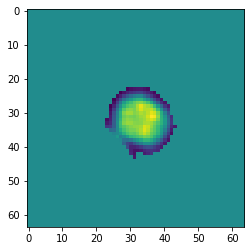

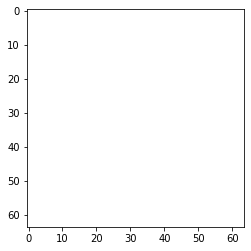

In [15]:
import matplotlib.pyplot as plt

x = np.array([val_tracks.appearances[2][25][1]])
xhat = AE(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])

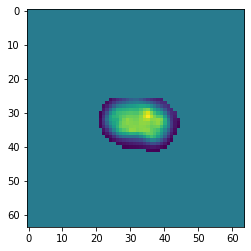

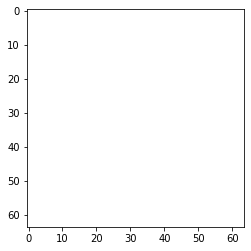

In [16]:
import matplotlib.pyplot as plt

x = np.array([val_tracks.appearances[2][13][6]])
xhat = AE(x).mean()

fig, ax = plt.subplots()
ax.imshow(x[0])

fig, ax = plt.subplots()
ax.imshow(xhat[0])